Data prep and Import Packages

In [1]:
from data_funcs import preprocess, cluster_feature_preprocess
from clustering import number_clusters_vis, kmeans_cluster, cluster_count_vis, cluster_preferences_vis, ks_clustering_test
import pandas as pd

customer_ref = 'data/WSA_data_customer.csv'
data_ref = 'data/WSA_data_order.csv'

# preprocess and data checks
cust_data, order_data = preprocess(customer_ref, data_ref)

# filter to dormant customers
order_data = order_data.merge(cust_data[['ACCOUNT_ID','ENGAGEMENT_SEGMENT']], left_on='ACCOUNT_ID', right_on='ACCOUNT_ID', how='inner')
order_data = order_data[order_data['ENGAGEMENT_SEGMENT']=='dormant']

Obtain our LLM (GPT-4o) category mappings

In [2]:
# use chat gpt with prompting to map our merchants into broad groups
merchants_mapping = pd.read_csv('data/merchants_mapping.csv')

# Join the mapping table onto the original table
order_data_merged = order_data.merge(merchants_mapping, left_on='MERCHANT_CATEGORY', right_on='Original Category', how='left')

# Check for missing mappings
missing_mappings = order_data_merged[order_data_merged['New Category'].isnull()]
print(f"Missing mappings: {missing_mappings.shape[0]}")

Missing mappings: 0


Feature Engineering and Preprocess for clustering

In [3]:
# other transformations prior to metric calculations
user_category_df = cluster_feature_preprocess(order_data_merged)

# Pivot the dataframe to get a matrix of user-category preference scores
preference_matrix = user_category_df.pivot(index='ACCOUNT_ID', columns='New Category', values='preference_score').fillna(0)

Elbow and Silhouette - Optimal clusters

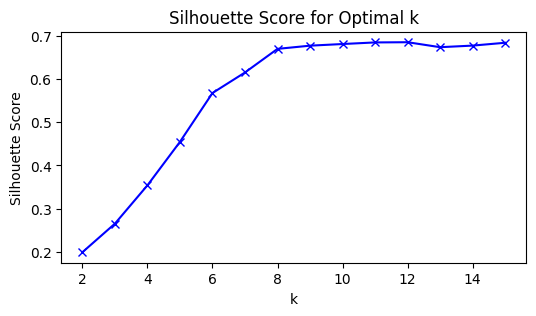

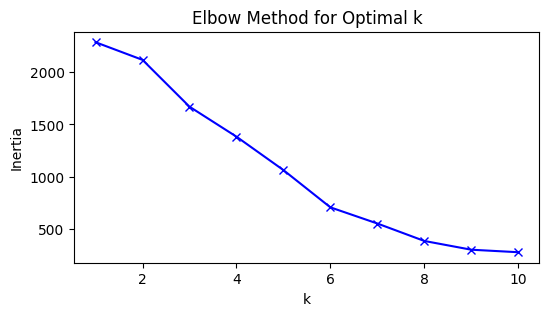

In [4]:
# check how many clusters we should use
# decide on number of clusters to use - optimal = 8
number_clusters_vis(preference_matrix, 2, 16)

Run Clustering - and check results

In [5]:
# run clustering with data and chosen amount of clusters
cluster_category_preferences, cluster_account_counts = kmeans_cluster(user_category_df, preference_matrix, 8)
cluster_category_preferences.head()

New Category,Apparel & Accessories,Automotive,Education & Training,Entertainment & Recreation,Finance & Insurance,Food & Beverage,Health & Beauty,Home & Garden,Professional & Business Services,Real Estate & Rental,Retail,Services,Technology & Electronics,Transportation & Logistics,Travel & Lodging
cluster,,,,,,,,,,,,,,,
0,0.028162,0.017926,0.101332,0.024447,0.070219,0.025163,0.020938,0.023972,0.107615,0.085060,0.026304,0.088425,0.154725,0.114955,0.110756
1,0.355395,0.063069,0.089697,0.059015,0.053440,0.034684,0.048275,0.041113,0.029660,NaN,0.057787,0.023155,0.049923,0.000000,0.094786
2,0.036043,0.064280,0.061706,0.036884,0.041906,0.389256,0.049920,0.039793,0.036274,0.026293,0.060253,0.039307,0.030267,0.051961,0.035855
3,0.029155,0.034349,0.000000,0.017312,NaN,0.046973,0.492753,0.061035,0.124921,NaN,0.079359,0.067473,0.014084,0.000000,0.032586
4,0.040235,0.022316,NaN,0.421252,0.100842,0.041332,0.051793,0.006648,0.007053,0.000000,0.049484,0.076650,0.043299,0.000000,0.139097


Check that our clusters are each significantly different to overall data set

In [6]:
ks_clustering_test(user_category_df)

Cluster: 0 {'ks_stat': 0.1525151480759547, 'p_value': 6.419790855631583e-24}
Cluster: 1 {'ks_stat': 0.1483852883433033, 'p_value': 2.508050164077473e-10}
Cluster: 2 {'ks_stat': 0.16466351491902148, 'p_value': 1.0420568620284942e-51}
Cluster: 3 {'ks_stat': 0.222369817413609, 'p_value': 2.490609755962994e-23}
Cluster: 4 {'ks_stat': 0.19427373437306597, 'p_value': 1.1908475665932902e-10}
Cluster: 5 {'ks_stat': 0.16373885619524192, 'p_value': 1.5885114697163785e-24}
Cluster: 6 {'ks_stat': 0.3873732188753704, 'p_value': 4.0937891623449164e-61}
Cluster: 7 {'ks_stat': 0.08933897329092602, 'p_value': 7.251052023653385e-05}


Visualise Preferences Results

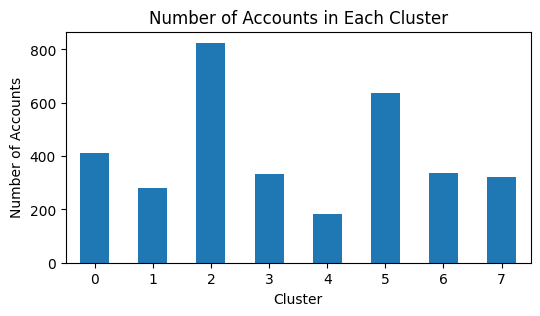

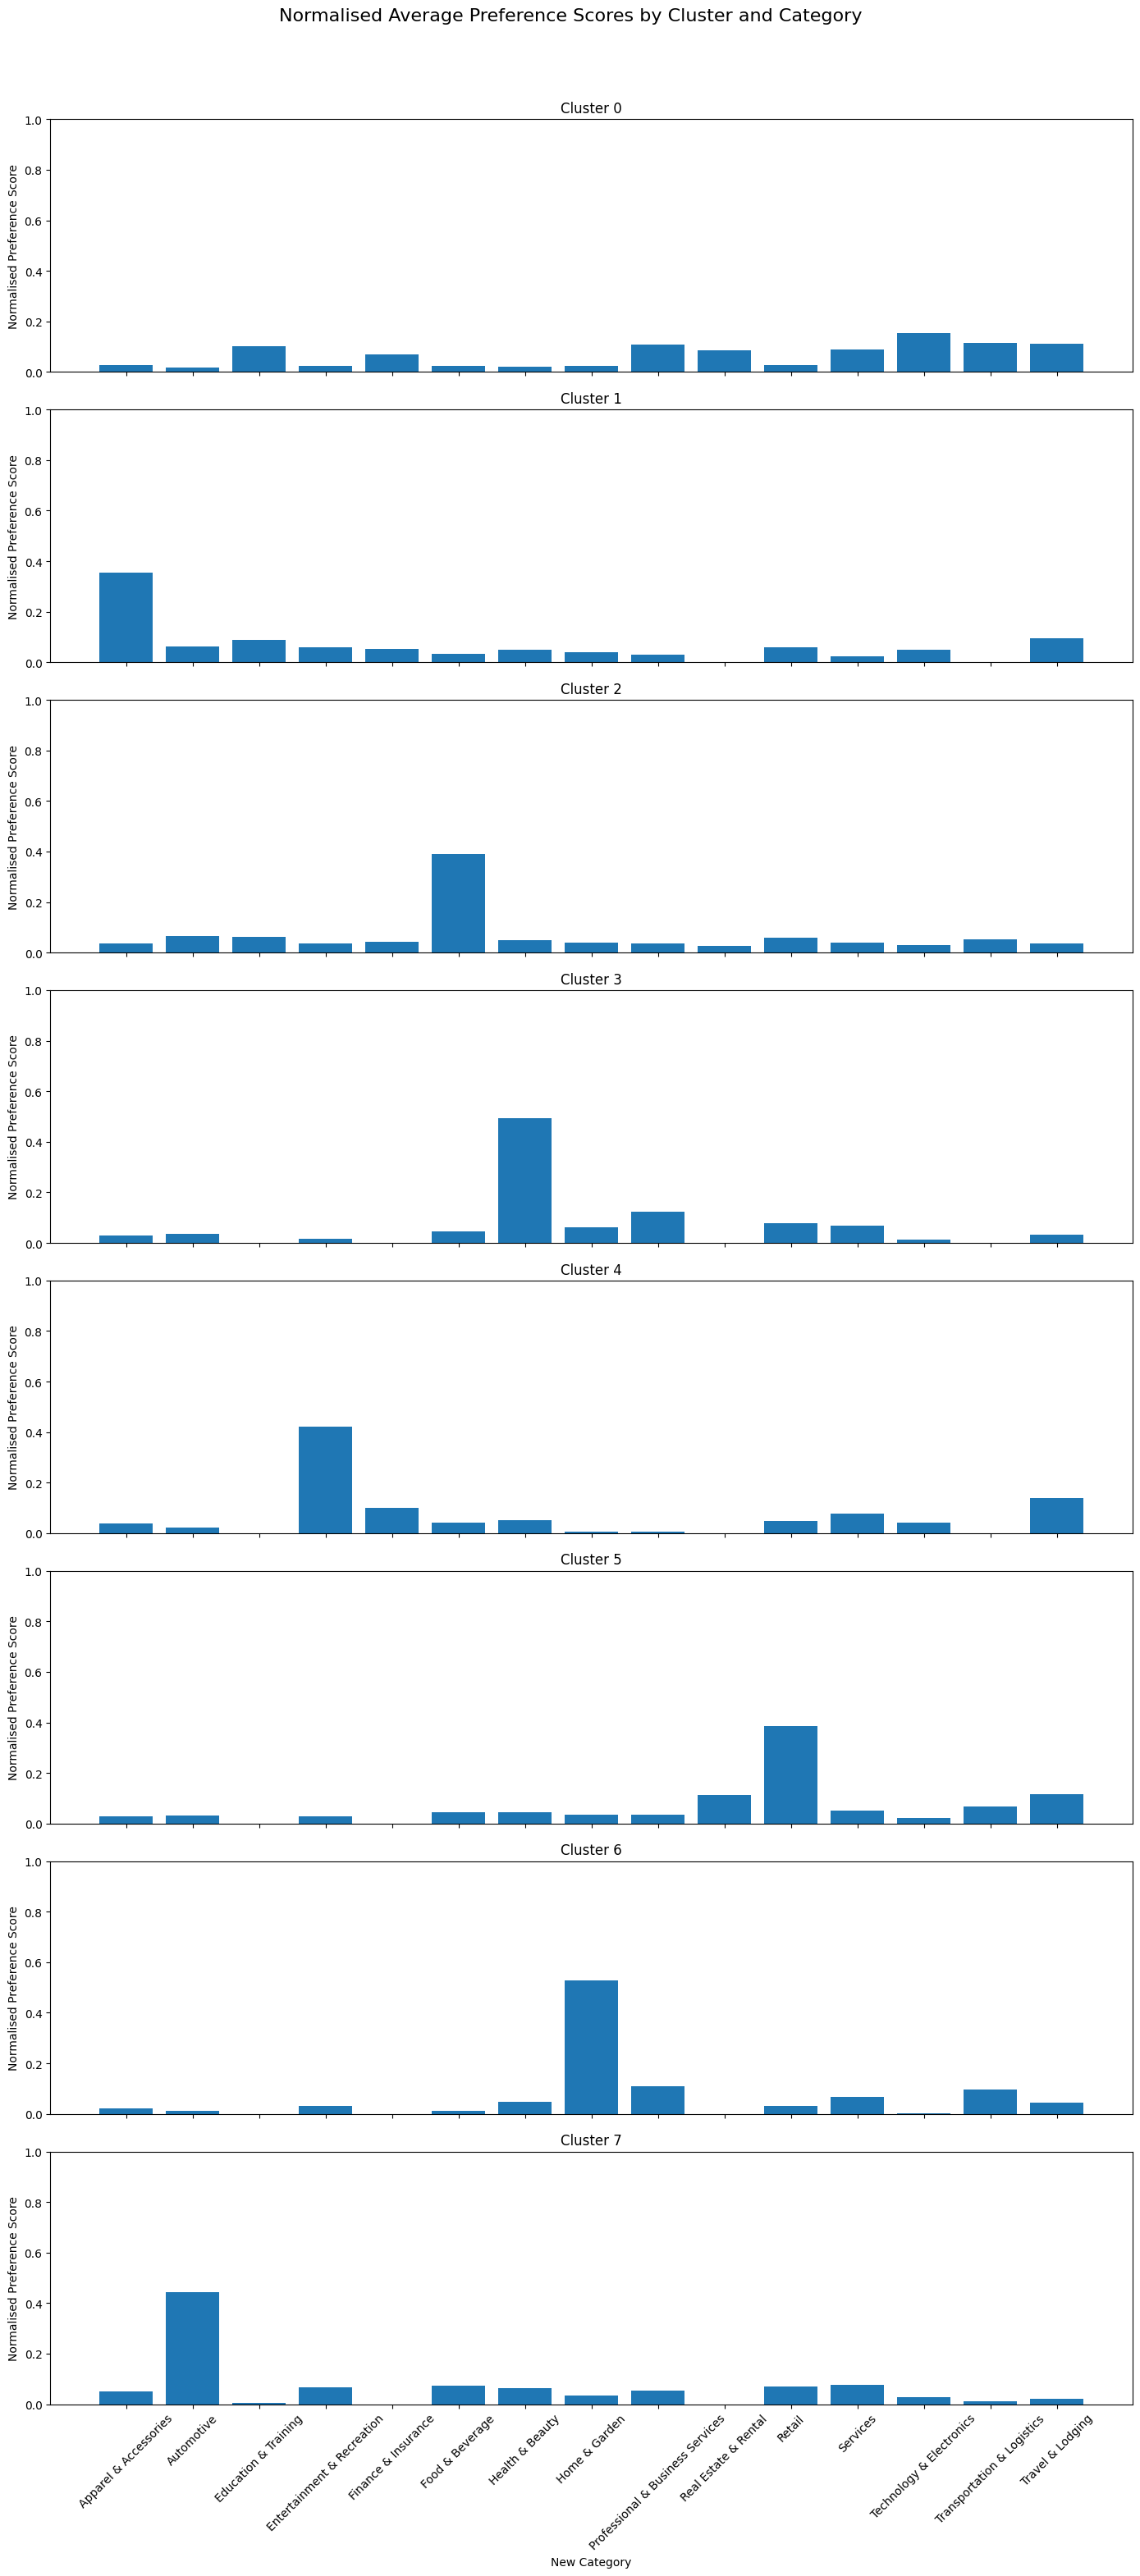

In [7]:
# visualise results
cluster_count_vis(cluster_account_counts)
cluster_preferences_vis(cluster_category_preferences)